# Import

In [3]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import time
import copy
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, SubsetRandomSampler
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import os
import re
import shutil
import sys
import ipywidgets
from scipy import stats
from os import listdir
from textwrap import wrap

#from pytorch_lightning.callbacks import ModelCheckpoint

NameError: name '_C' is not defined

In [2]:
AVAIL_GPUS = torch.cuda.device_count()
print(AVAIL_GPUS)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1


# Model

In [ ]:
class block_1d(pl.LightningModule):
    def __init__(self,in_dim,out_dim,activation=nn.ReLU,dropout = 0.5):
#         self.learning_rate = lr
        super(block_1d, self).__init__()
        self.block = nn.Sequential(
            #nn.BatchNorm1d(in_dim),
#             nn.Dropout(dropout),
            nn.Linear(in_dim,out_dim, bias=True),
#             nn.Linear(in_dim,out_dim),
            activation(),
        )

    def forward(self, x):
        out = self.block(x)
        return out
###############################################################################
class res_block_1d(pl.LightningModule):
    def __init__(self, in_dim, out_dim, activation=nn.ReLU,dropout = 0.5):
        super(res_block_1d, self).__init__()
        self.activation = activation()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_dim),
            nn.Dropout(dropout),
            nn.Linear(in_dim, out_dim, bias=True),
            activation(),
            nn.BatchNorm1d(out_dim),
            nn.Dropout(dropout),
            nn.Linear(out_dim, out_dim, bias=True),
            activation(),
        )

    def forward(self, x):
#         out = self.activation(self.block(x) + x)
        out = self.block(x) + x
        return out
################################################################################  
class resnet(pl.LightningModule):
    def __init__(self, in_dim, out_dim, layers):
        #layers: list of layer_spec
        #layer_spec: list of [block_type, block dimenssion, block activation, dropout]
        super(resnet, self).__init__()
        self.loss = nn.MSELoss()
        self.num_layers = len(layers)+1
        for index in range(self.num_layers):
            if index == 0 :
                setattr(self, "layer_" + str(index), layers[index][0](in_dim, layers[index][1], layers[index][2],layers[index][3]))
            elif index == self.num_layers-1:
                setattr(self, "layer_" + str(index), nn.Linear(layers[index-1][1], out_dim))
            else:
                setattr(self, "layer_" + str(index), layers[index][0](layers[index-1][1], layers[index][1],layers[index][2],layers[index][3]))
    
    def forward(self, x):
        for index in range(self.num_layers):
            x = getattr(self, "layer_" + str(index))(x)
        return x
###################################################################################    
    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                                   batch_size=batch_size,
                                                   #sampler=train_sampler,
                                                   drop_last = False,
                                                   shuffle=True,
                                                   num_workers=1,
                                                   pin_memory = True)
        return train_loader

    def val_dataloader(self):
        validation_loader = torch.utils.data.DataLoader(dataset = valid_dataset,
                                                        batch_size=batch_size,
                                                        #sampler=valid_sampler,
                                                        drop_last = False,
                                                        shuffle=True,
                                                        num_workers=1,
                                                        pin_memory = True)
        return validation_loader

    def test_dataloader(self):
        test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                                  batch_size=batch_size,
                                                  #sampler=test_sampler,
                                                  drop_last = False, 
                                                  shuffle=False,
                                                  num_workers=1,
                                                  pin_memory = False)
        return test_loader   
#################################################################################    
    def training_step(self, batch, batch_idx):
        data, target = batch
        preds = self(data)
        loss = self.loss(preds, target)
        self.log('train_loss_step', loss)#,prog_bar=True)
        return {'loss': loss}

    def training_step_end(self, outputs):
        return outputs
    
    def training_epoch_end(self, outputs) -> None:
        self.log('train_loss_epoch',torch.stack([x['loss'] for x in outputs]).mean())
        
    ########################################################    
        
    def validation_step(self, batch, batch_idx):
        data, target = batch
        preds = self(data)
        loss = self.loss(preds, target)
        self.log('val_loss_step', loss)#, prog_bar=True)
        return {'val_loss':loss}
    

    def validation_step_end(self, outputs):
        return outputs

    def validation_epoch_end(self,outputs)->None:
        self.log('val_loss_epoch',torch.stack([x['val_loss'] for x in outputs]).mean())
        
    ########################################################
  
    def test_step(self, batch, batch_idx):
        data, target = batch
        preds = self(data)
        loss = self.loss(preds, target)
        self.log("test_loss", loss)#, prog_bar=True)
        return {'test_loss':loss}

    def test_epoch_end(self,outputs)->None:
        torch.stack([x['test_loss'] for x in outputs]).mean()

    ########################################################

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr= 1e-3)
        return optimizer

In [4]:
x_train_idx = [['Generation_type_data_818.xlsx', 0, 8, 8], ['Generation_type_data_818.xlsx', 1, 8, 17], ['Generation_type_data_818.xlsx', 2, 8, 26], ['Generation_type_data_818.xlsx', 3, 5, 32], 
               ['Generation_type_data_818.xlsx', 3, 8, 35], ['Generation_type_data_818.xlsx', 4, 8, 44], ['Generation_type_data_818.xlsx', 5, 8, 53], ['Generation_type_data_818.xlsx', 6, 8, 62], 
               ['Generation_type_data_818.xlsx', 7, 8, 71], ['COPPER_configuration_818.xlsx', 4, 0, 85], ['annual_growth_818.xlsx', 0, 0, 99], ['annual_growth_818.xlsx', 0, 1, 100],
               ['annual_growth_818.xlsx', 0, 2, 101], ['annual_growth_818.xlsx', 1, 0, 102], ['annual_growth_818.xlsx', 1, 1, 103], ['annual_growth_818.xlsx', 1, 2, 104], ['annual_growth_818.xlsx', 2, 0, 105], 
               ['annual_growth_818.xlsx', 2, 1, 106], ['annual_growth_818.xlsx', 2, 2, 107], ['annual_growth_818.xlsx', 3, 0, 108], ['annual_growth_818.xlsx', 3, 1, 109], ['annual_growth_818.xlsx', 3, 2, 110], 
               ['annual_growth_818.xlsx', 4, 1, 112], ['annual_growth_818.xlsx', 4, 2, 113], ['annual_growth_818.xlsx', 5, 0, 114], ['annual_growth_818.xlsx', 5, 1, 115], ['annual_growth_818.xlsx', 5, 2, 116], 
               ['annual_growth_818.xlsx', 6, 0, 117], ['annual_growth_818.xlsx', 6, 1, 118], ['annual_growth_818.xlsx', 6, 2, 119], ['annual_growth_818.xlsx', 7, 0, 120], ['annual_growth_818.xlsx', 7, 1, 121], 
               ['annual_growth_818.xlsx', 7, 2, 122], ['annual_growth_818.xlsx', 8, 0, 123], ['annual_growth_818.xlsx', 8, 1, 124], ['annual_growth_818.xlsx', 8, 2, 125], ['annual_growth_818.xlsx', 9, 0, 126], 
               ['annual_growth_818.xlsx', 9, 1, 127], ['annual_growth_818.xlsx', 9, 2, 128]]

In [5]:
y_train_idx = [['carbon_ap.xlsx', ['Alberta'], '2030', 3], ['carbon_ap.xlsx', ['Alberta'], '2040', 4], ['carbon_ap.xlsx', ['Alberta'], '2050', 5], ['carbon_ap.xlsx', ['Saskatchewan'], '2030', 6], 
               ['carbon_ap.xlsx', ['Saskatchewan'], '2040', 7], ['carbon_ap.xlsx', ['Saskatchewan'], '2050', 8], ['carbon_ap.xlsx', ['Manitoba'], '2030', 9], ['carbon_ap.xlsx', ['Manitoba'], '2040', 10], 
               ['carbon_ap.xlsx', ['Manitoba'], '2050', 11], ['carbon_ap.xlsx', ['Ontario'], '2030', 12], ['carbon_ap.xlsx', ['Ontario'], '2040', 13], ['carbon_ap.xlsx', ['Ontario'], '2050', 14], 
               ['carbon_ap.xlsx', ['Quebec'], '2030', 15], ['carbon_ap.xlsx', ['Quebec'], '2040', 16], ['carbon_ap.xlsx', ['Quebec'], '2050', 17], ['carbon_ap.xlsx', ['New Brunswick'], '2030', 18], 
               ['carbon_ap.xlsx', ['New Brunswick'], '2040', 19], ['carbon_ap.xlsx', ['New Brunswick'], '2050', 20], ['carbon_ap.xlsx', ['Newfoundland and Labrador'], '2030', 21], 
               ['carbon_ap.xlsx', ['Newfoundland and Labrador'], '2040', 22], ['carbon_ap.xlsx', ['Newfoundland and Labrador'], '2050', 23], ['carbon_ap.xlsx', ['Nova Scotia'], '2030', 24], 
               ['carbon_ap.xlsx', ['Nova Scotia'], '2040', 25], ['carbon_ap.xlsx', ['Nova Scotia'], '2050', 26], ['carbon_ap.xlsx', ['Prince Edward Island'], '2030', 27], 
               ['carbon_ap.xlsx', ['Prince Edward Island'], '2040', 28], ['carbon_ap.xlsx', ['Prince Edward Island'], '2050', 29], ['Total_Generation_ABA.xlsx', ['gas'], 'Alberta.a', 57], 
               ['Total_Generation_ABA.xlsx', ['gas'], 'Saskatchewan.a', 58], ['Total_Generation_ABA.xlsx', ['gas'], 'Manitoba.a', 59], ['Total_Generation_ABA.xlsx', ['gas'], 'Quebec.a', 62], 
               ['Total_Generation_ABA.xlsx', ['gas'], 'New Brunswick.a', 64], ['Total_Generation_ABA.xlsx', ['gas'], 'Nova Scotia.a', 67], ['Total_Generation_ABA.xlsx', ['wind'], 'Prince Edward Island.a', 120], 
               ['Total_Generation_ABA.xlsx', ['gas'], 'Alberta.a', 174], ['Total_Generation_ABA.xlsx', ['gas'], 'Saskatchewan.a', 175], ['Total_Generation_ABA.xlsx', ['gas'], 'Manitoba.a', 176], 
               ['Total_Generation_ABA.xlsx', ['gas'], 'Ontario.a', 177], ['Total_Generation_ABA.xlsx', ['gas'], 'Quebec.a', 179], ['Total_Generation_ABA.xlsx', ['gas'], 'New Brunswick.a', 181], 
               ['Total_Generation_ABA.xlsx', ['gas'], 'Nova Scotia.a', 184], ['Total_Generation_ABA.xlsx', ['wind'], 'Prince Edward Island.a', 237], ['Total_Generation_ABA.xlsx', ['gas'], 'Alberta.a', 291], 
               ['Total_Generation_ABA.xlsx', ['gas'], 'Saskatchewan.a', 292], ['Total_Generation_ABA.xlsx', ['gas'], 'Manitoba.a', 293], ['Total_Generation_ABA.xlsx', ['gas'], 'Ontario.a', 294], 
               ['Total_Generation_ABA.xlsx', ['gas'], 'Quebec.a', 296], ['Total_Generation_ABA.xlsx', ['gas'], 'New Brunswick.a', 298], ['Total_Generation_ABA.xlsx', ['gas'], 'Nova Scotia.a', 301], 
               ['Total_Generation_ABA.xlsx', ['gas'], 'Prince Edward Island.a', 302], ['Total_Generation_ABA.xlsx', ['wind'], 'Ontario.a', 346], ['Canada_gen_outline.xlsx', ['gas'], '2030', 387], 
               ['Canada_gen_outline.xlsx', ['gas'], '2040', 388], ['Canada_gen_outline.xlsx', ['gas'], '2050', 389], ['Canada_gen_outline.xlsx', ['wind'], '2030', 399], ['Canada_gen_outline.xlsx', ['wind'], '2040', 400], 
               ['Canada_gen_outline.xlsx', ['wind'], '2050', 401]]

In [6]:
layers = [[block_1d,128,nn.ReLU,0]]
#     layers = []
num_blocks = 8

for i in range(num_blocks):
    layers.append([res_block_1d,128,nn.ReLU,0.2])  


In [7]:
dim_input = 39
dim_output = 57

In [11]:
new_model = resnet.load_from_checkpoint("Model.ckpt", in_dim = dim_input, out_dim = dim_output, layers = layers )

In [82]:
print(y_train_idx[56])

['Canada_gen_outline.xlsx', ['wind'], '2050', 401]


<Figure size 432x288 with 0 Axes>

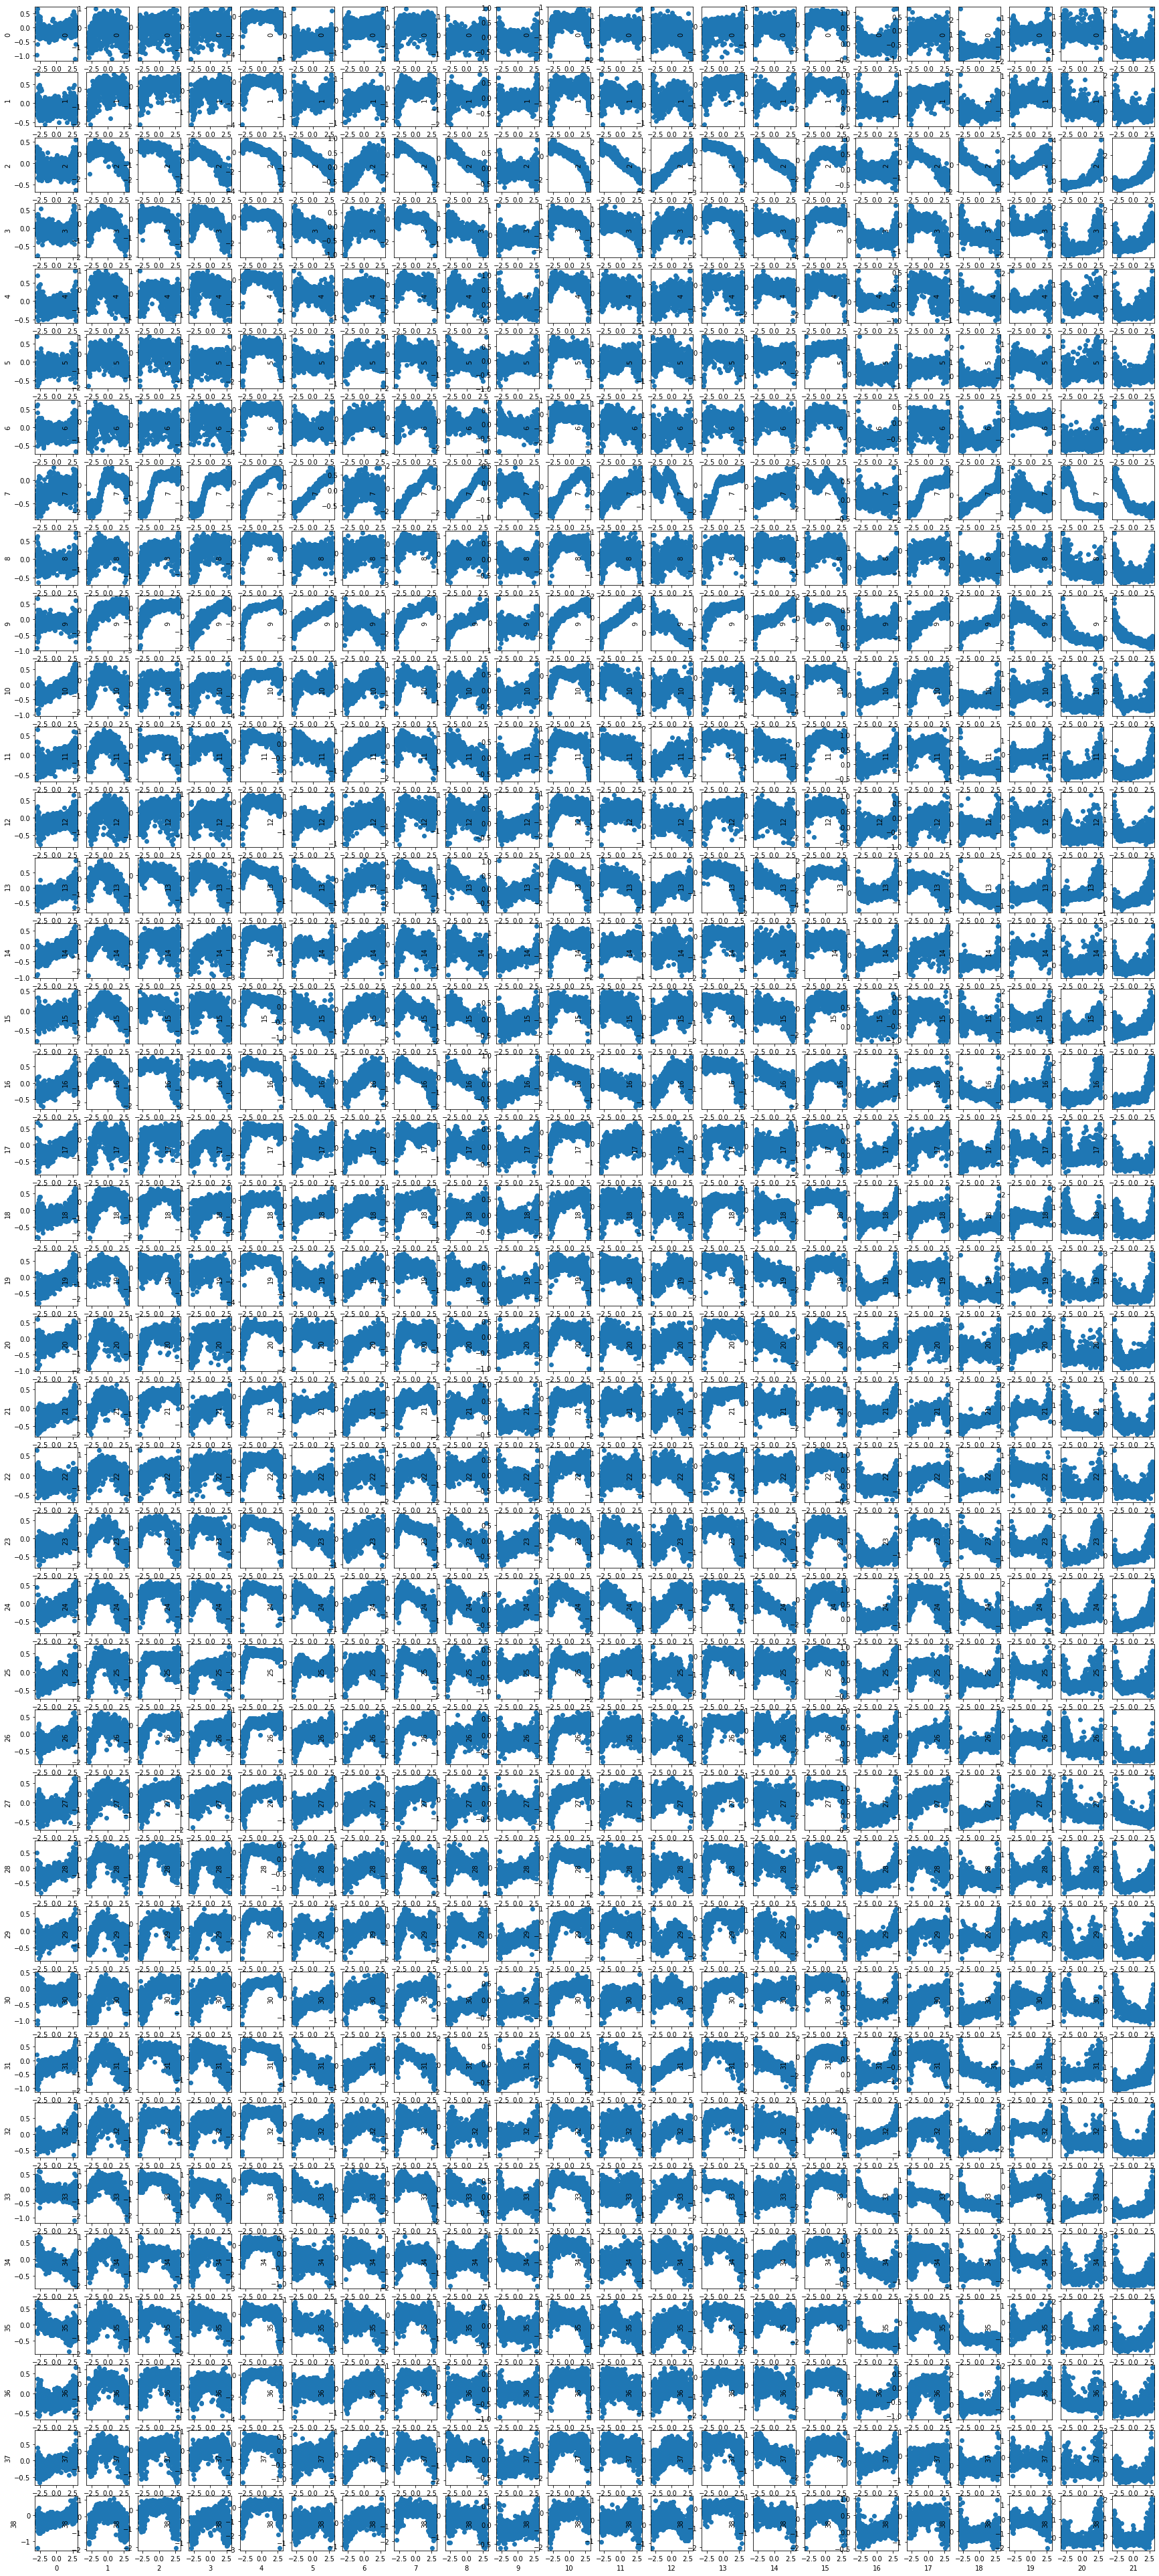

In [12]:
# Predictions with the model by randomly changing each inputs (1000 sample of each) and plot output vs each input
rand_list = np.random.uniform(-3, 3, 1000)
z1 = torch.FloatTensor(rand_list)
main_outputs = [0, 9, 10, 11, 15, 17, 20 ,21, 22, 24, 31, 32, 33, 37, 40, 41, 42, 45, 47, 50, 54, 56]
num_col = len(main_outputs)
num_row = dim_input
f = plt.figure()   
f,axsi = plt.subplots(num_row, num_col, figsize=(30,70))

for i in range(dim_input):
    x_train_new = torch.zeros(1000,dim_input)
    x_train_new[:,i] = z1
    with torch.no_grad():
        y_new = new_model (x_train_new)

    for j in range(num_col):
        axsi[i][j].scatter(x_train_new[:,i], y_new[:,main_outputs[j]])
        axsi[i][j].set(xlabel= j, ylabel= i)
        
plt.savefig("inputs_2_outputs.jpg" , dpi=200)

<Figure size 432x288 with 0 Axes>

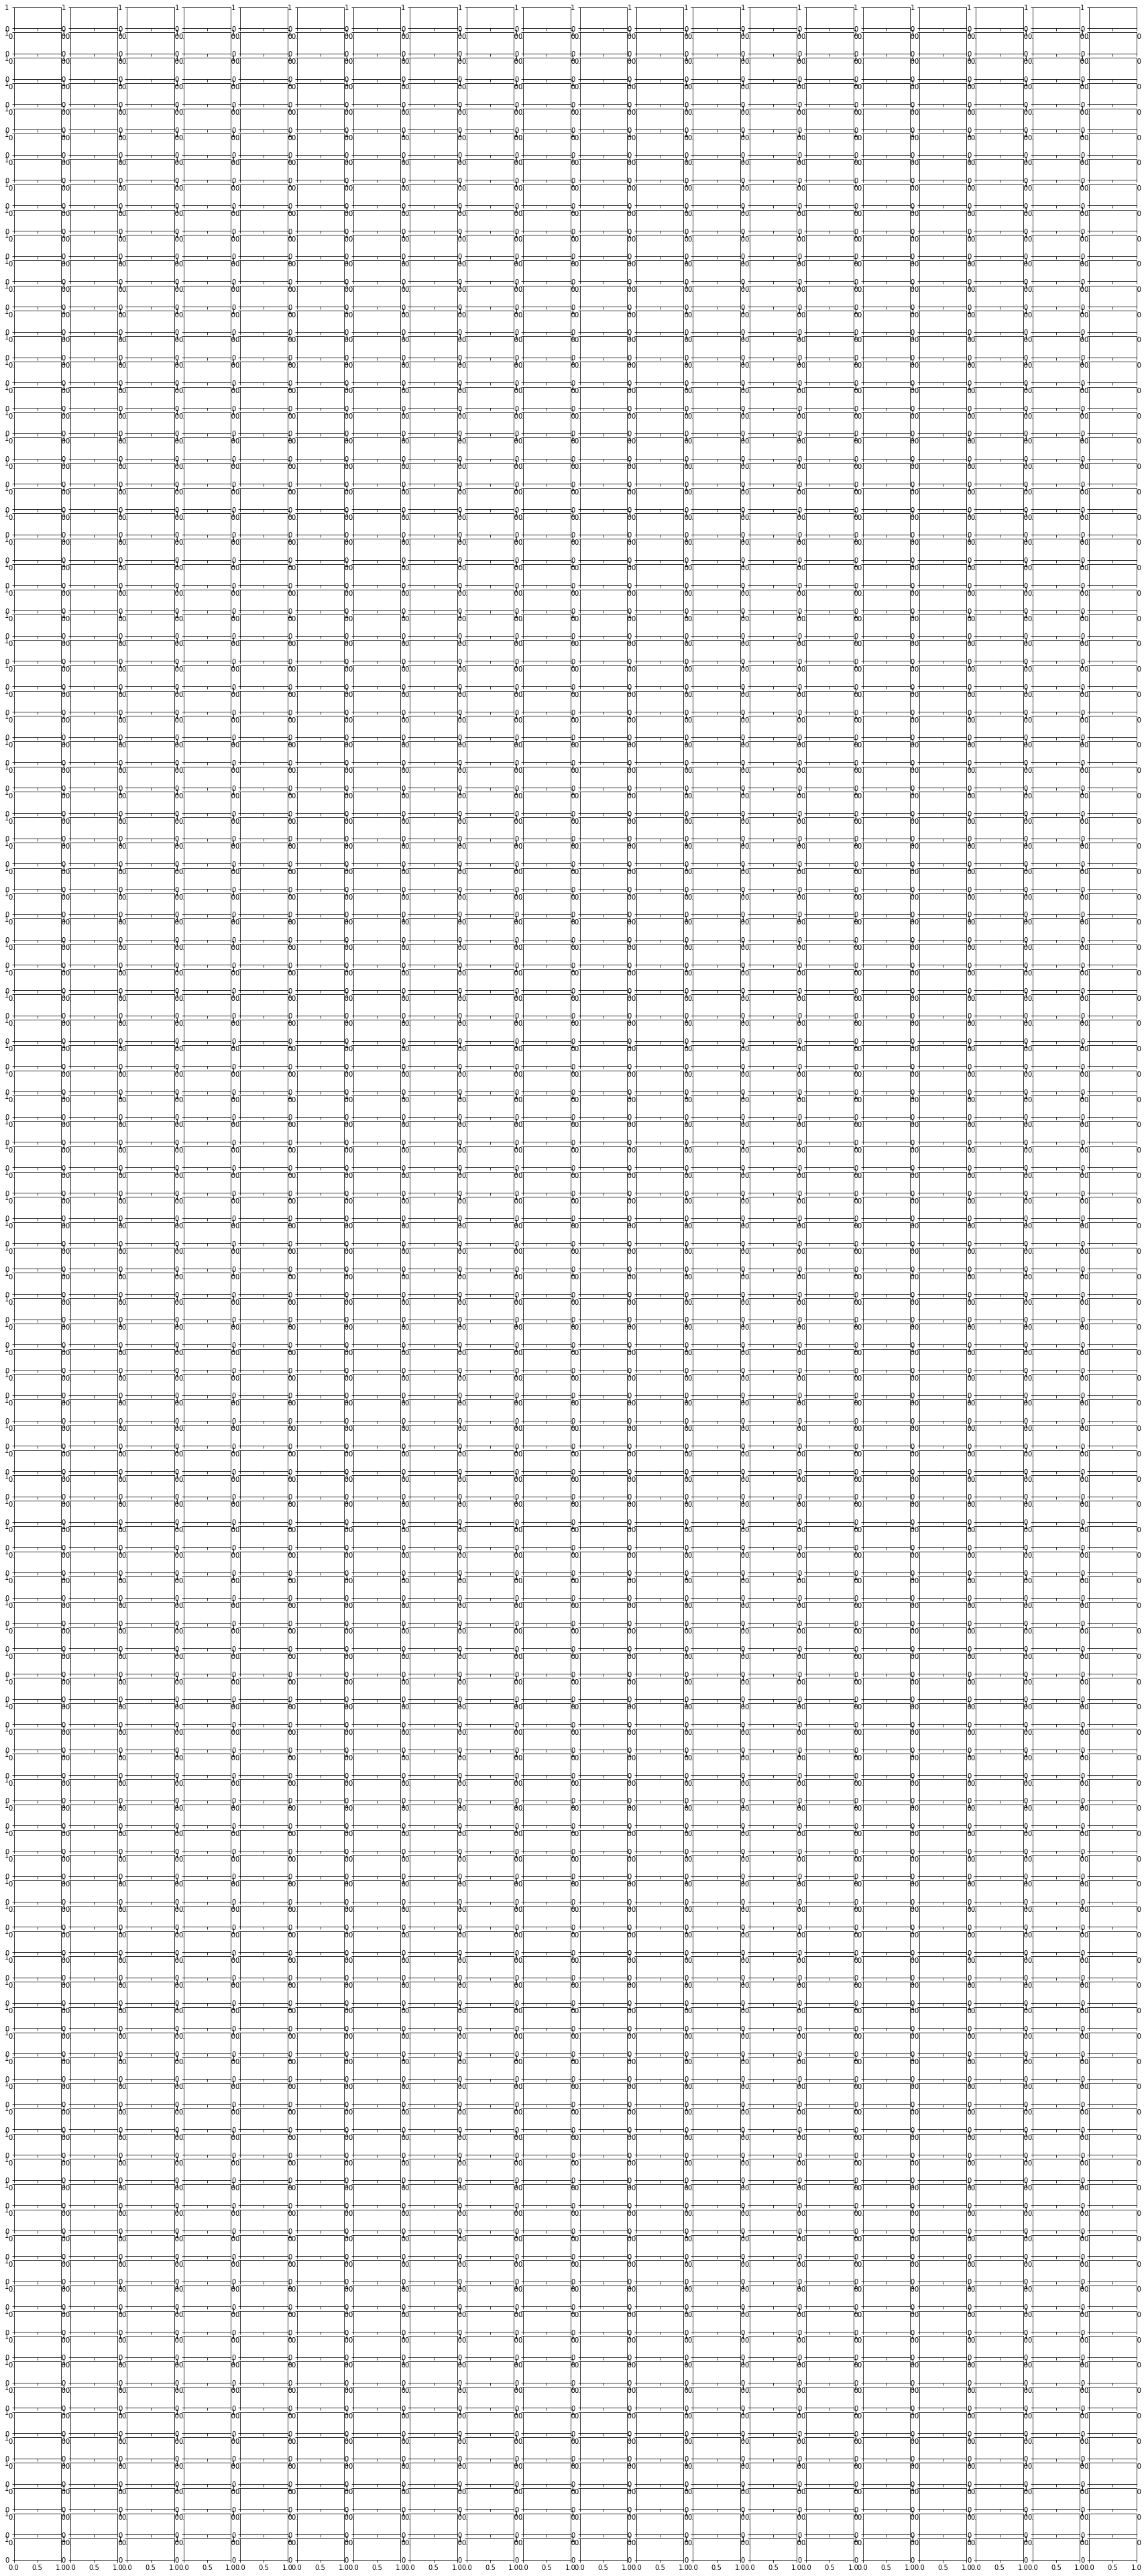

<Figure size 432x288 with 0 Axes>

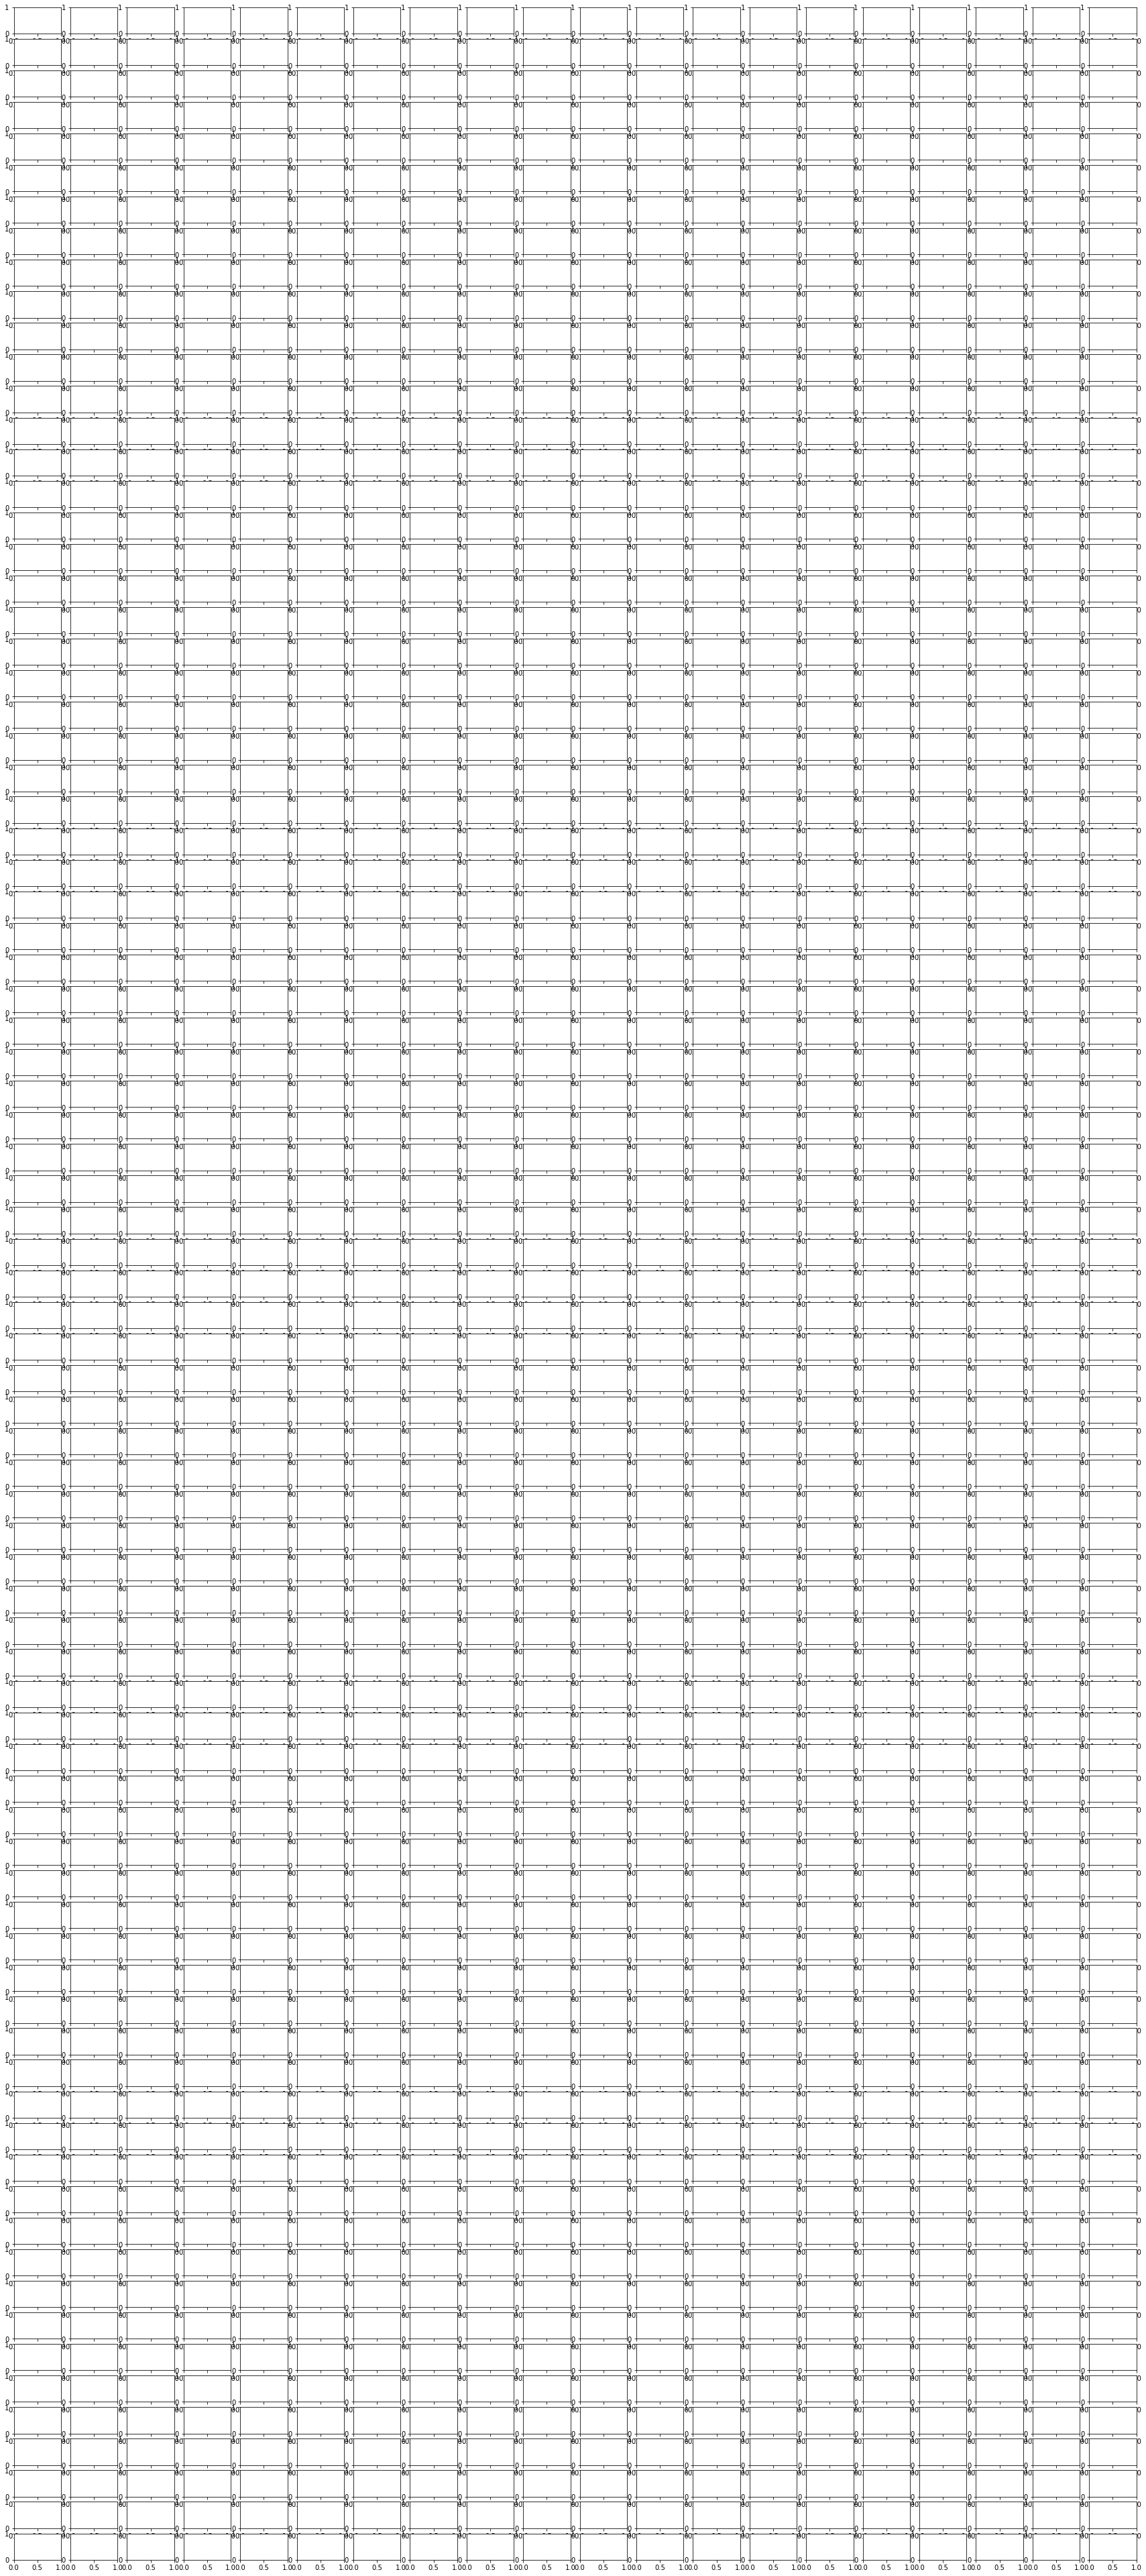

<Figure size 432x288 with 0 Axes>

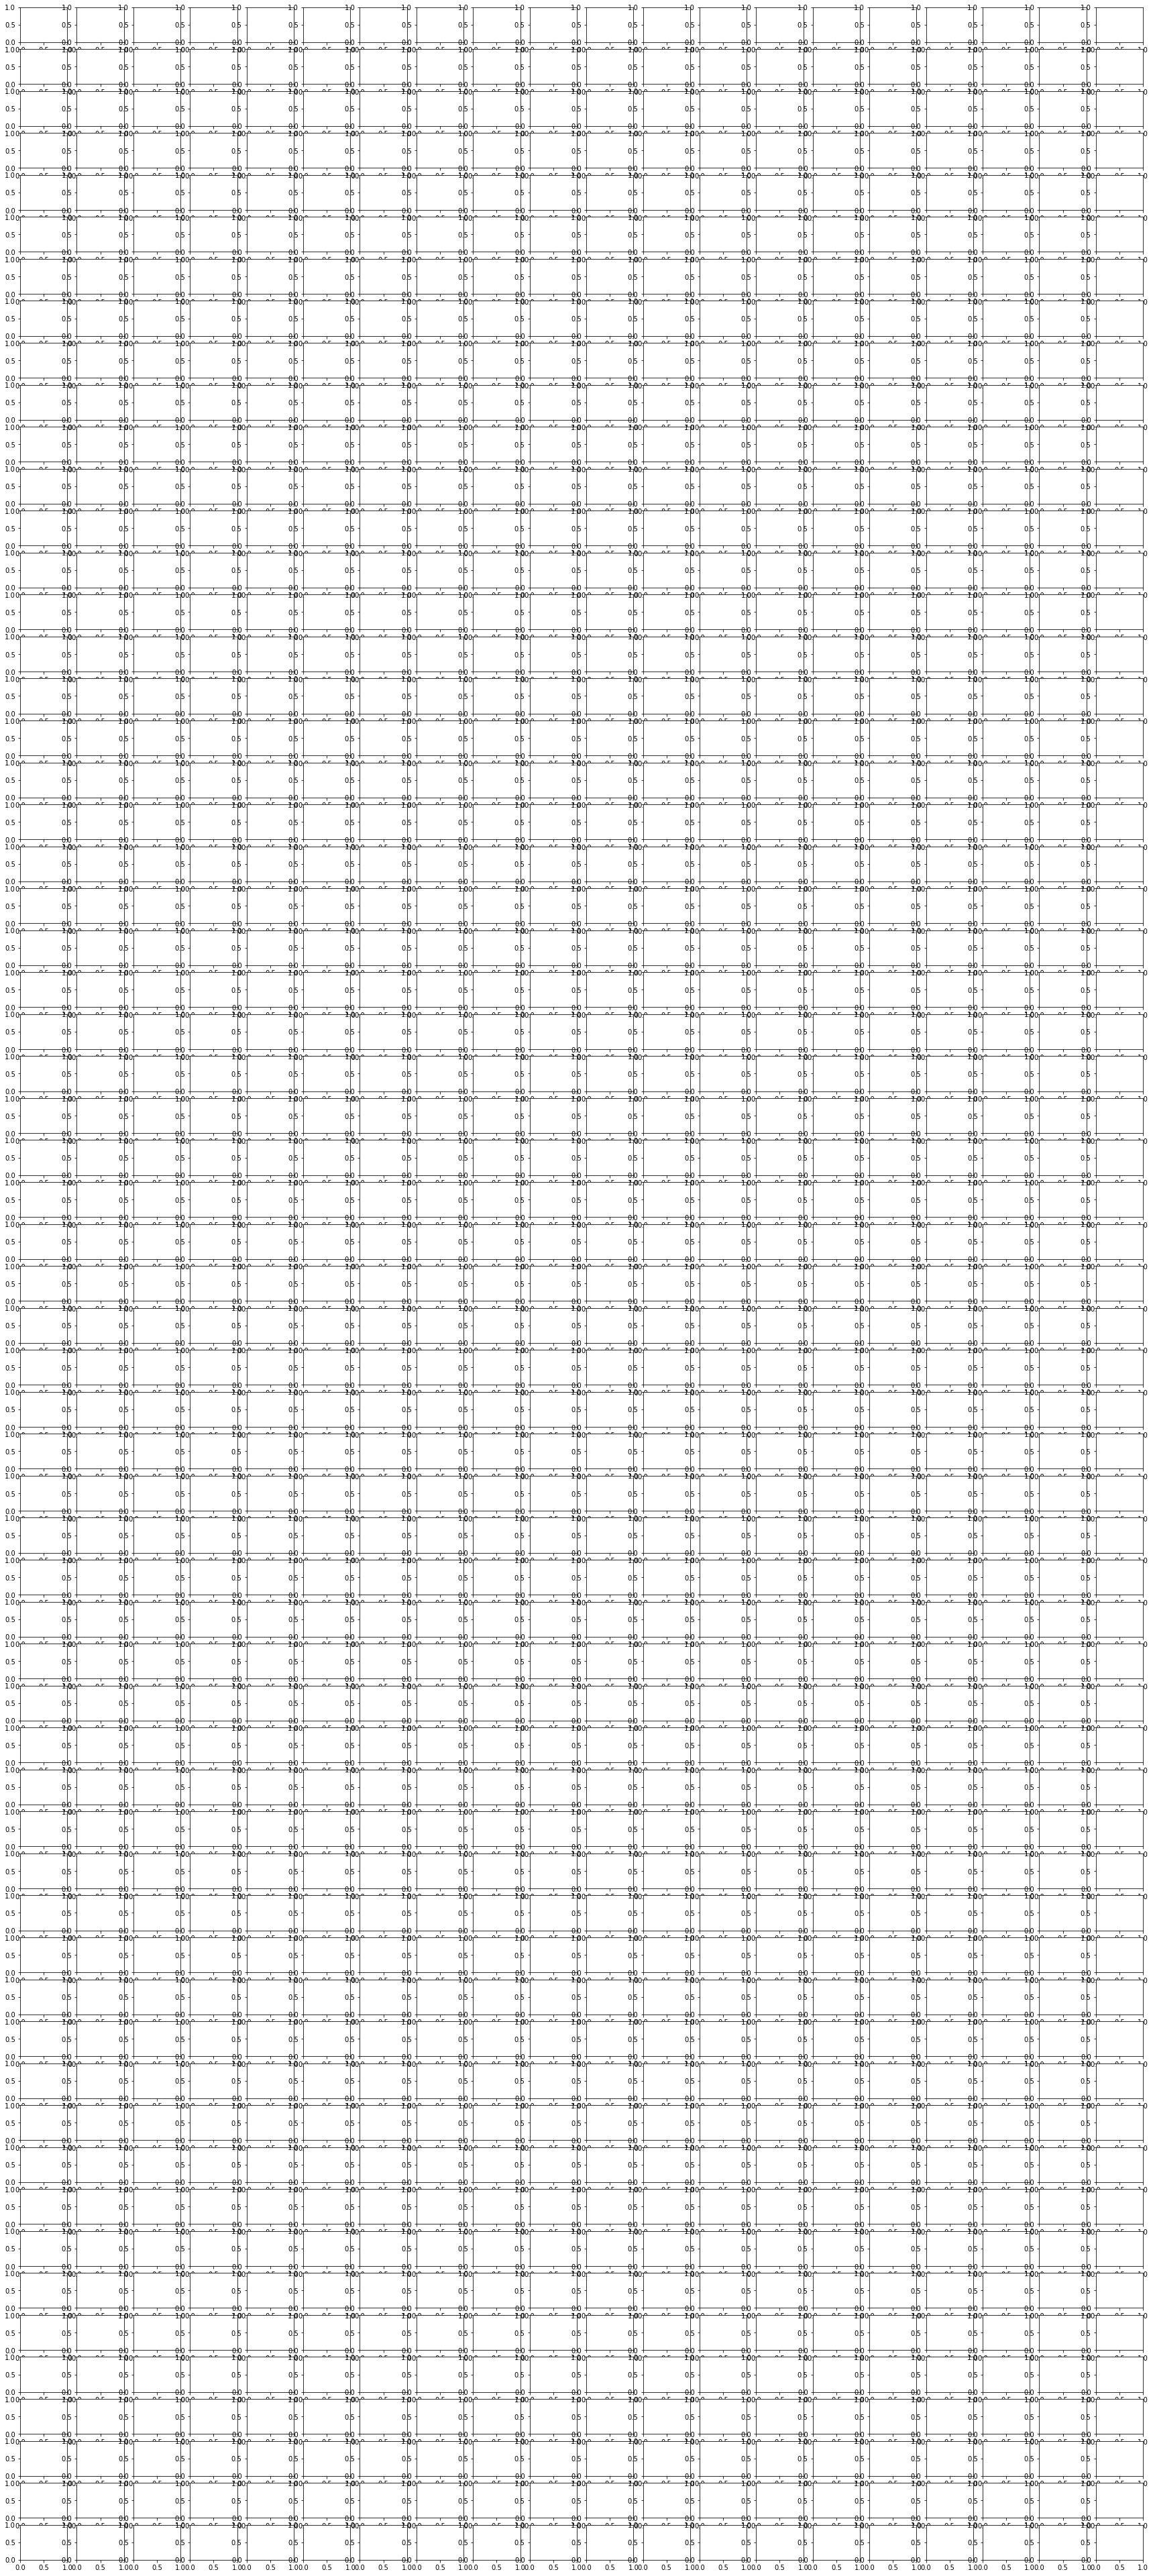

In [17]:
# Plot outputs correlations and get r2

from sklearn.metrics import r2_score
r2_dict = {}
gen_plot = False
# num_plot = 40
num_col = 20
num_row = y_train.shape[1]


num_figures = int(np.ceil(y_train.shape[1]/num_col))


for n in range(num_figures):
    num_row = y.shape[1]-n*num_col
    f = plt.figure()   
    f,axs1 = plt.subplots(num_row, num_col, figsize=(30,70))
    

    for i in range(num_col*n,  y_train.shape[1]):
        r2_list = []
        for j in range(num_col*n, min(num_col*(n+1), y_train.shape[1])):
            if j > i :
                break
            r2 = r2_score(y_train[:,i], y_train[:,j])
            if r2 > 0.8:
                r2_list.append(j)  
                r2_dict[i] = r2_list
            if gen_plot == True:
                axs1[i-n*num_col][j%num_col].scatter(y_train[:,i], y_train[:,j])
    #             axs[i, j%num_col].set_title("\n".join(wrap(str(y_train_idx[i]), 30)), fontsize=10)
                axs1[i-n*num_col][j%num_col].set(xlabel= j, ylabel= i)


    plt.savefig("output_correlations_%d.jpg" %(n), dpi=200)

In [68]:
print(r2_dict)
main_outputs = [0, 9, 10, 11, 15, 17, 20, 24,31,37,42,45,47,21,22,32,33,40,41,50,54,56]
main_outputs.sort()
print(main_outputs)

NameError: name 'r2_dict' is not defined

<Figure size 432x288 with 0 Axes>

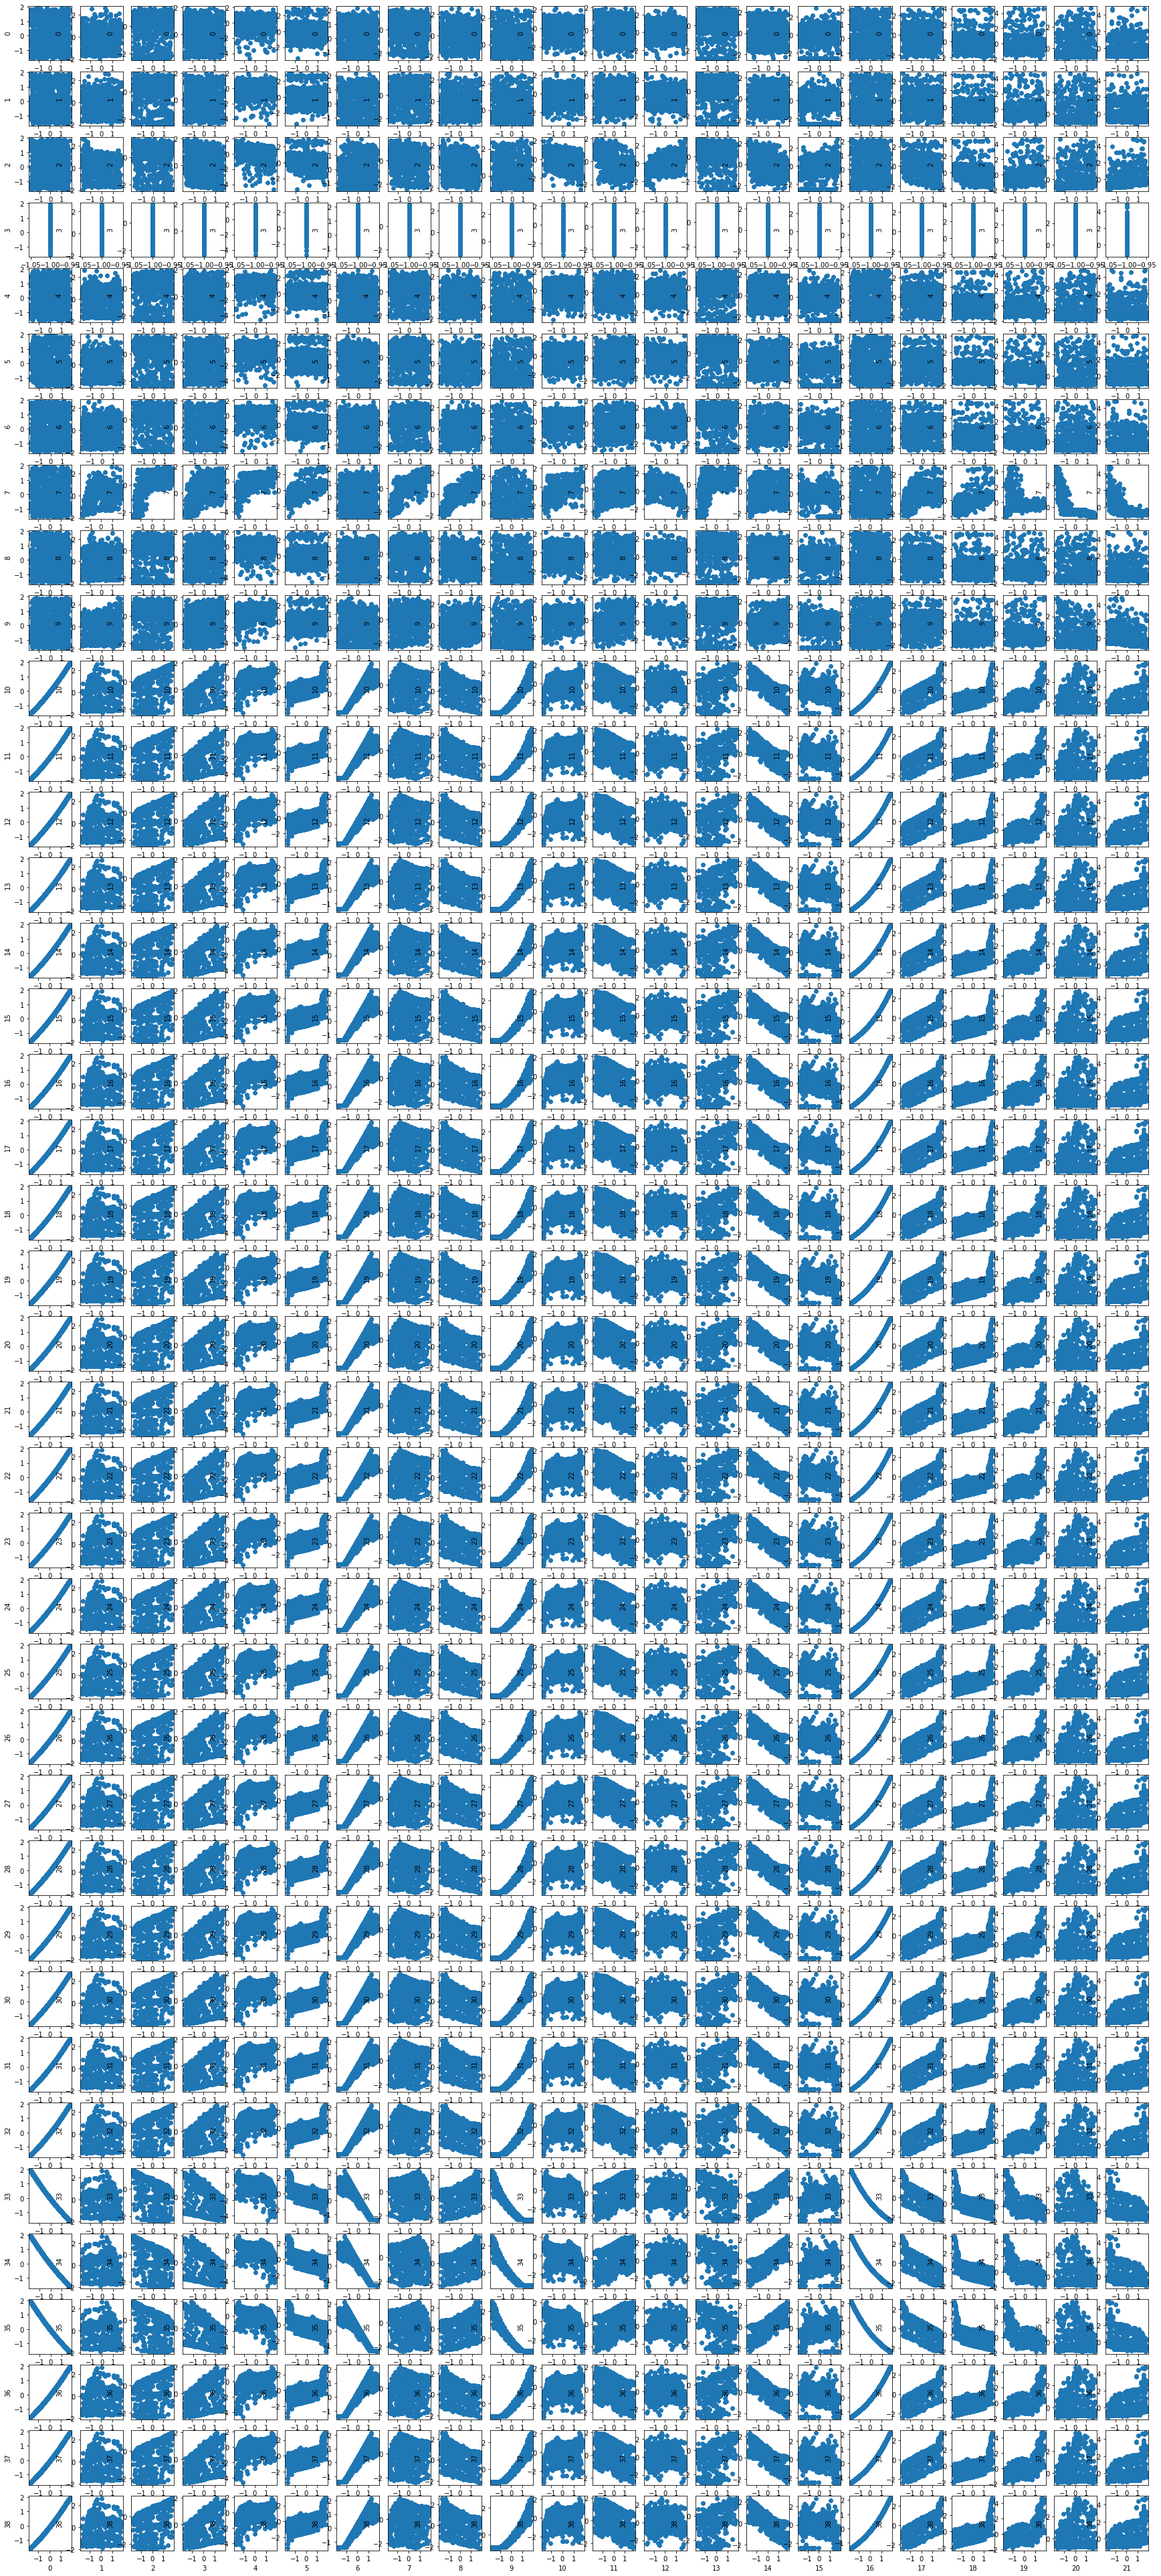

In [33]:
# Plot outputs vs inputs

gen_plot = True
num_col = len(main_outputs)
num_row = x_train.shape[1]


# num_figures = int(np.ceil(y_train.shape[1]/num_col))

num_figures = 1
for n in range(num_figures):
    f = plt.figure()   
    f,axs = plt.subplots(num_row, num_col, figsize=(30,70))

    for i in range(num_col*n,  x_train.shape[1]):
        for j in range(num_col*n, num_col):
            if gen_plot == True:
                x, y = [-10, 10],[-10, 10]
                axs[i][j].scatter(x_train[:,i], y_train[:,main_outputs[j]])
                axs[i][j].set(xlabel= j, ylabel= i)


    plt.savefig("inputs_outputs_%d.jpg" %(n), dpi=200)